In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, average_precision_score
from scipy.stats import randint, uniform
from sklearn.model_selection import cross_validate, cross_val_predict

In [2]:
# Load dataset
data = pd.read_csv("data/processed/fraud.csv")

X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P'].astype(int)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())

Train shape: (12336, 44)
Test shape: (3084, 44)
Fraud ratio in train: 0.05982490272373541
Fraud ratio in test: 0.05998702983138781


In [4]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),              
    ('resample', SMOTEENN(random_state=42)),  
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
    ))
])

In [5]:
param_dist = {
    'xgb__n_estimators': randint(300, 800),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__gamma': uniform(0, 0.5)
}

In [6]:
pr_auc_scorer = make_scorer(average_precision_score, needs_proba=True)
scoring = pr_auc_scorer

In [7]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=40,
    scoring=scoring,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [8]:
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print(f"Best CV PR-AUC: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


Best Parameters: {'xgb__colsample_bytree': np.float64(0.749816047538945), 'xgb__gamma': np.float64(0.4753571532049581), 'xgb__learning_rate': np.float64(0.15639878836228102), 'xgb__max_depth': 7, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 402, 'xgb__subsample': np.float64(0.7783331011414365)}
Best CV PR-AUC: nan


In [9]:
cv_scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'pr_auc': make_scorer(average_precision_score, needs_proba=True)   
}

cv_results = cross_validate(
    random_search.best_estimator_,
    X_train,
    y_train,
    scoring=cv_scoring,
    cv=5
)


c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\En Xin\Ap

c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\En Xin\Ap

c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\En Xin\Ap

c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\En Xin\Ap

c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\En Xin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\_param_validation.py", line 196, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "c:\Users\En Xin\Ap

In [10]:
metric_table = pd.DataFrame(cv_results)

In [11]:
metric_table

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc,test_pr_auc
0,1.092281,0.029873,0.923015,0.383333,0.466216,0.420732,NaN,NaN
1,1.117731,0.020123,0.929469,0.417178,0.462585,0.438710,NaN,NaN
2,1.119685,0.019369,0.926632,0.411458,0.537415,0.466077,NaN,NaN
3,1.149606,0.019755,0.932712,0.444444,0.486486,0.464516,NaN,NaN
4,1.128050,0.019109,0.930685,0.435028,0.520270,0.473846,NaN,NaN


In [12]:
print("\nMean Recall across folds:", metric_table['test_recall'].mean())


Mean Recall across folds: 0.49459459459459454


In [13]:
print("\nMean Precision across folds:", metric_table['test_precision'].mean())


Mean Precision across folds: 0.41828845476182225


In [14]:
print("\nMean Precision across folds:", metric_table['test_pr_auc'].mean())


Mean Precision across folds: nan


In [15]:
y_pred_cv = cross_val_predict(
    random_search.best_estimator_,
    X_train, y_train,
    cv=5,
    method='predict'
)
cm = confusion_matrix(y_train, y_pred_cv)
print(cm)


[[11089   509]
 [  373   365]]


In [16]:
print(classification_report(y_train, y_pred_cv))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     11598
           1       0.42      0.49      0.45       738

    accuracy                           0.93     12336
   macro avg       0.69      0.73      0.71     12336
weighted avg       0.93      0.93      0.93     12336



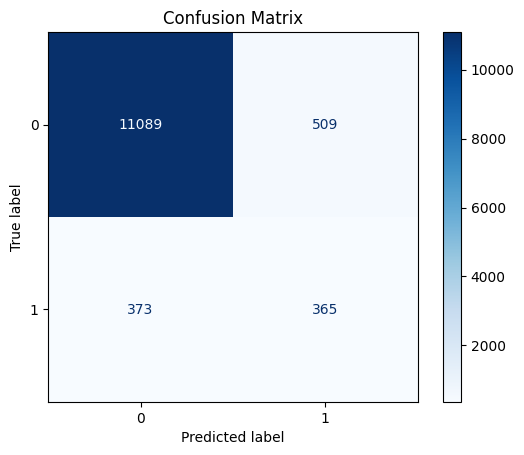

In [17]:
disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix")
plt.show()

In [18]:
best_model = random_search.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)
print(f"Test Recall: {recall_score(y_test, y_pred):.4f}")
test_pr_auc = average_precision_score(y_test, y_prob)
print("Test PR-AUC:", test_pr_auc)
print(confusion_matrix(y_test, y_pred))

Test Recall: 0.5405
Test PR-AUC: 0.49576459654259025
[[2782  117]
 [  85  100]]


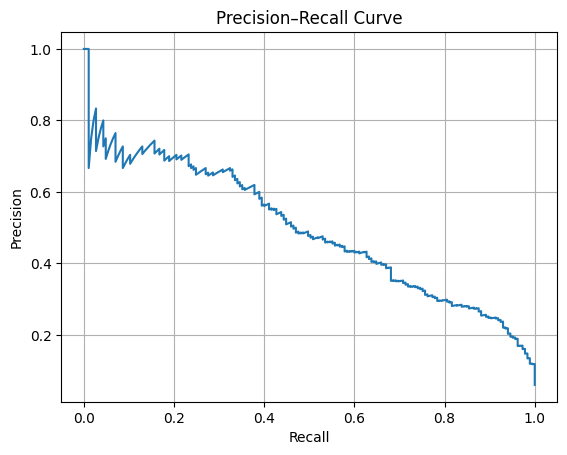

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()
